# Cloob Model Assessment

Diagnostic notebook for the trained `cloob_model` diffusion pipeline.  
Covers: training curves, output tensor inspection, decode validity, SRV metrics, confusion analysis, circuit structure, and guidance scale sweep.

## 1. Setup & Imports

In [1]:
import sys, os, ast, random
from pathlib import Path
from collections import Counter

import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl

# Work from the project root so all relative config paths resolve correctly
PROJECT_ROOT = Path(os.getcwd()).parent
os.chdir(PROJECT_ROOT)

sys.path.insert(0, str(PROJECT_ROOT / "src"))

from my_genQC.inference.eval_metrics import UnitaryFrobeniusNorm, UnitaryInfidelityNorm
from my_genQC.inference.evaluation_helper import get_unitaries, get_srvs
from my_genQC.inference.sampling import generate_tensors, decode_tensors_to_backend
from my_genQC.pipeline.diffusion_pipeline import DiffusionPipeline
from my_genQC.platform.simulation import Simulator, CircuitBackendType
from my_genQC.platform.tokenizer.circuits_tokenizer import CircuitTokenizer
from my_genQC.utils.misc_utils import infer_torch_device, get_entanglement_bins, plot_image_grid
from my_genQC.dataset import circuits_dataset
from my_genQC.utils.config_loader import load_config, load_tensor

from quantum_diffusion.data.dataset import DatasetLoader
from quantum_diffusion.evaluation.evaluator import SRVEvaluator

device = torch.device(infer_torch_device())
print(f"Device: {device}")
print(f"Working directory: {os.getcwd()}")

[INFO]: Cuda device has a capability of 8.6 (>= 8), allowing tf32 matmul.
Device: cuda
Working directory: /workspace/qcircuit-generation


## 2. Training Curves

In [2]:
model_dir = Path("models/trained/cloob_model")

# Per-step training losses (one value per line)
train_losses = np.loadtxt(model_dir / "fit_losses.txt")
# Validation losses: columns are (cumulative_step, loss)
valid_data = np.loadtxt(model_dir / "fit_valid_losses.txt")
valid_steps = valid_data[:, 0]
valid_losses = valid_data[:, 1]

print(f"Training steps : {len(train_losses)}")
print(f"Validation epochs: {len(valid_losses)}")
print(f"Final train loss (last 100 avg): {train_losses[-100:].mean():.6f}")
print(f"Final valid loss              : {valid_losses[-1]:.6f}")

Training steps : 433000
Validation epochs: 50
Final train loss (last 100 avg): 0.009898
Final valid loss              : 0.000099


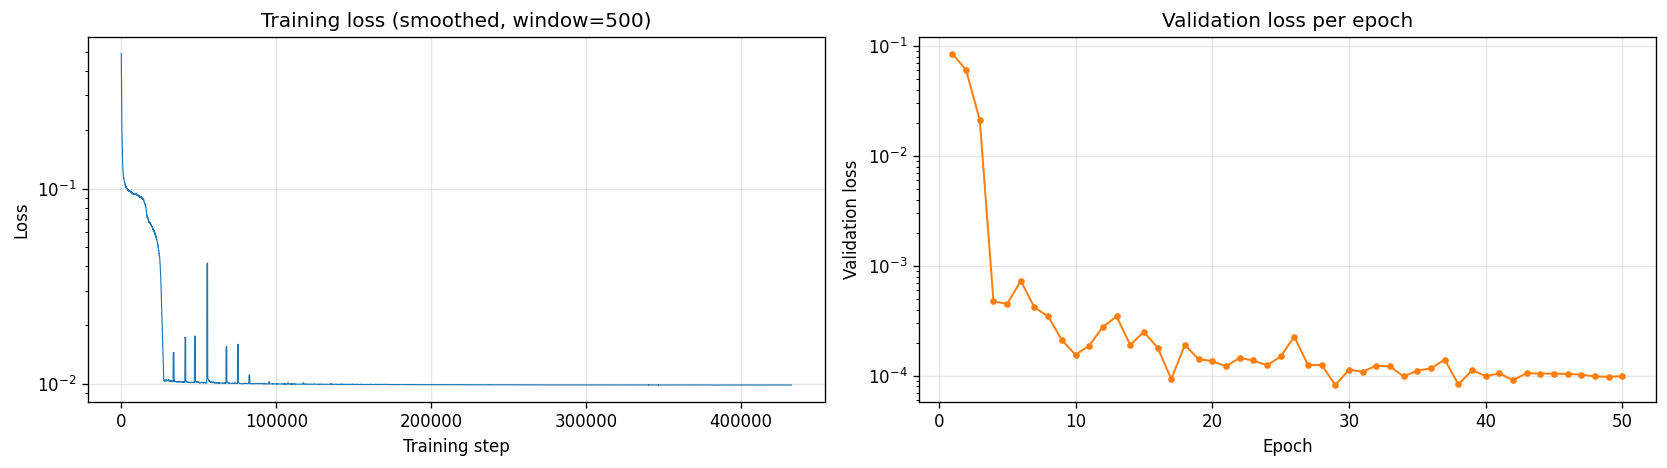

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4), dpi=120)

# -- Left: full training loss with smoothing --
ax = axes[0]
window = 500
smoothed = np.convolve(train_losses, np.ones(window) / window, mode="valid")
ax.plot(smoothed, linewidth=0.7, color="C0")
ax.set_xlabel("Training step")
ax.set_ylabel("Loss")
ax.set_title(f"Training loss (smoothed, window={window})")
ax.set_yscale("log")
ax.grid(True, alpha=0.3)

# -- Right: validation loss per epoch --
ax = axes[1]
epochs = np.arange(1, len(valid_losses) + 1)
ax.plot(epochs, valid_losses, marker="o", markersize=3, linewidth=1.2, color="C1")
ax.set_xlabel("Epoch")
ax.set_ylabel("Validation loss")
ax.set_title("Validation loss per epoch")
ax.set_yscale("log")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

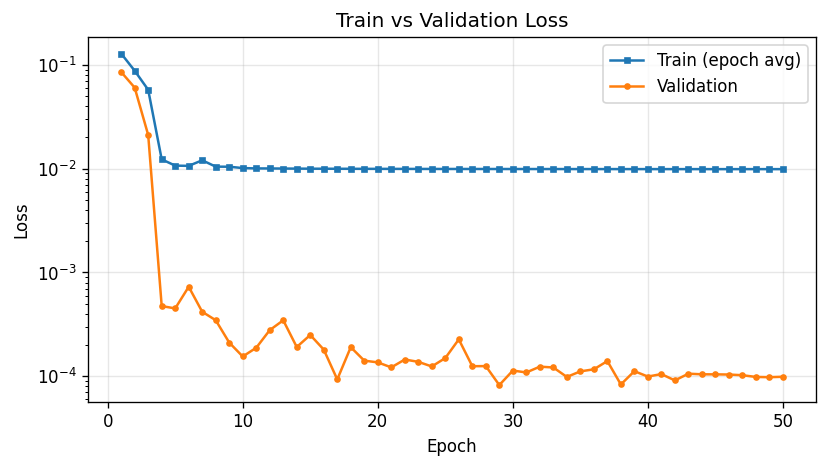

Best validation loss at epoch 29: 0.000082


In [4]:
# Overlay: epoch-averaged training loss vs validation loss
steps_per_epoch = len(train_losses) // len(valid_losses)
epoch_train_losses = [
    train_losses[i * steps_per_epoch : (i + 1) * steps_per_epoch].mean()
    for i in range(len(valid_losses))
]

fig, ax = plt.subplots(figsize=(7, 4), dpi=120)
ax.plot(epochs, epoch_train_losses, marker="s", markersize=3, label="Train (epoch avg)")
ax.plot(epochs, valid_losses, marker="o", markersize=3, label="Validation")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Train vs Validation Loss")
ax.set_yscale("log")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Check for overfitting
best_valid_epoch = int(np.argmin(valid_losses)) + 1
print(f"Best validation loss at epoch {best_valid_epoch}: {valid_losses[best_valid_epoch - 1]:.6f}")
if best_valid_epoch < len(valid_losses) - 2:
    print(f"WARNING: Validation loss increased after epoch {best_valid_epoch} — possible overfitting.")
else:
    print("Validation loss is still decreasing or stable at the end of training.")

## 3. Load Model & Dataset

In [5]:
import hydra

NUM_SAMPLES = 500  # keep small for interactive diagnostics

with hydra.initialize(version_base=None, config_path="../conf"):
    cfg = hydra.compose(config_name="config.yaml", overrides=["evaluation=clip_rn50"])
    cfg = cfg["evaluation"]

cfg.wandb.enable = False
cfg.num_samples = NUM_SAMPLES

evaluator = SRVEvaluator(config=cfg)

[INFO]: Cuda device has a capability of 8.6 (>= 8), allowing tf32 matmul.
2026-02-13 13:53:00 - quantum_diffusion.evaluation.evaluator - INFO - Running w/o wandb


2026-02-13 13:53:00 - quantum_diffusion.data.dataset - INFO - Detected preprocessed dataset. Loading directly...


[INFO]: Loading tensor from `./datasets/paper_quditkit/srv_5q_dataset/dataset/ds_x.safetensors` onto device: cuda.


[INFO]: Loading tensor from `./datasets/paper_quditkit/srv_5q_dataset/dataset/ds_y.safetensors` onto device: cuda.


[INFO]: Instantiated config_dataset from given config on cuda.
2026-02-13 13:53:00 - quantum_diffusion.data.dataset - INFO - Dataset loaded from ./datasets/paper_quditkit/srv_5q_dataset


[INFO]: `genQC.models.unet_qc.QC_Cond_UNet` instantiated from given `config` on cuda.
[INFO]: Loading model from `models/trained/cloob_model/model.pt` onto device: cuda.
[INFO]: `genQC.models.unet_qc.QC_Cond_UNet`. Freeze model: True


[INFO]: Loaded local text encoder weights from ./models/encoders/clip_rn50_yfcc_epoch_28.pt
[WARNING]: 0 missing keys, first 10: []
[WARNING]: 339 unexpected keys, first 10: ['visual.conv1.weight', 'visual.bn1.weight', 'visual.bn1.bias', 'visual.bn1.running_mean', 'visual.bn1.running_var', 'visual.bn1.num_batches_tracked', 'visual.conv2.weight', 'visual.bn2.weight', 'visual.bn2.bias', 'visual.bn2.running_mean']


[INFO]: `my_genQC.models.frozen_open_clip.CachedFrozenOpenCLIPEmbedder` instantiated from given `config` on cuda.
[INFO]: `my_genQC.models.frozen_open_clip.CachedFrozenOpenCLIPEmbedder`. Found no key `save_type` in `config`. No state dict loaded.
[INFO]: `my_genQC.models.frozen_open_clip.CachedFrozenOpenCLIPEmbedder`. Freeze model: True


[INFO]: `genQC.models.unet_qc.QC_Cond_UNet` instantiated from given `config` on cuda.
[INFO]: Loading model from `models/trained/cloob_model/embedder.pt` onto device: cuda.
[INFO]: `genQC.models.unet_qc.QC_Cond_UNet`. Freeze model: True
[WARNING]: The value 0 is reserved for background tokens, i.e. qubit time position which are not effected by gates.
[WARNING]: Automatically incrementing all vocabulary values by one ...


In [6]:
# Model summary
pipeline = evaluator.pipeline
dataset = evaluator.dataset

n_params_model = sum(p.numel() for p in pipeline.model.parameters())
n_params_embedder = sum(p.numel() for p in pipeline.embedder.parameters())

print(f"Model parameters    : {n_params_model:,}")
print(f"Embedder parameters : {n_params_embedder:,}")
print(f"Dataset shape (x)   : {dataset.x.shape}")
print(f"Dataset labels (y)  : {len(dataset.y)} entries")
print(f"Gate pool           : {dataset.gate_pool}")
print(f"Num qubits          : {evaluator.num_qubits}")
print(f"System size         : {evaluator.system_size}")
print(f"Max gates           : {evaluator.max_gates}")
print(f"Guidance mode       : {pipeline.guidance_sample_mode}")

Model parameters    : 5,393,556
Embedder parameters : 5,393,556
Dataset shape (x)   : torch.Size([497496, 5, 28])
Dataset labels (y)  : 497496 entries
Gate pool           : ['h', 'cx']
Num qubits          : 5
System size         : 5
Max gates           : 28
Guidance mode       : rescaled


## 4. Generate Samples

In [7]:
tensors_out = evaluator.generate_tensors(save_output=False)
print(f"Generated tensor shape: {tensors_out.shape}")

2026-02-13 13:53:04 - quantum_diffusion.evaluation.evaluator - INFO - Starting tensor generation...


  0%|          | 0/50 [00:00<?, ?it/s]

[INFO]: (generate_comp_tensors) Generated 500 tensors
2026-02-13 13:53:12 - quantum_diffusion.evaluation.evaluator - INFO - Finished tensor generation. Took 7.48 seconds.


Generated tensor shape: torch.Size([500, 5, 28])


## 5. Visualize Raw Output Tensors

Compare generated circuit tensors (top) with ground truth dataset tensors (bottom).  
Each image is a `[num_qubits x max_gates]` matrix where nonzero entries represent gates.

Generated circuits:


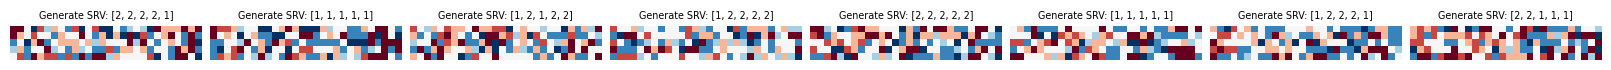

Ground truth circuits:


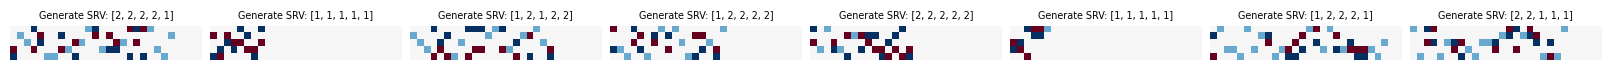

In [8]:
n_show = 8
sample_idx = evaluator.idx[:n_show]

gt_tensors = dataset.x[sample_idx].cpu().float()
gen_tensors = tensors_out[:n_show].cpu().float()
gt_labels = [str(dataset.y[i])[:40] for i in sample_idx]

print("Generated circuits:")
plot_image_grid(gen_tensors, labels=gt_labels, figsize=(16, 3), cols=n_show, cmap="RdBu", labels_fs="x-small")
plt.show()

print("Ground truth circuits:")
plot_image_grid(gt_tensors, labels=gt_labels, figsize=(16, 3), cols=n_show, cmap="RdBu", labels_fs="x-small")
plt.show()

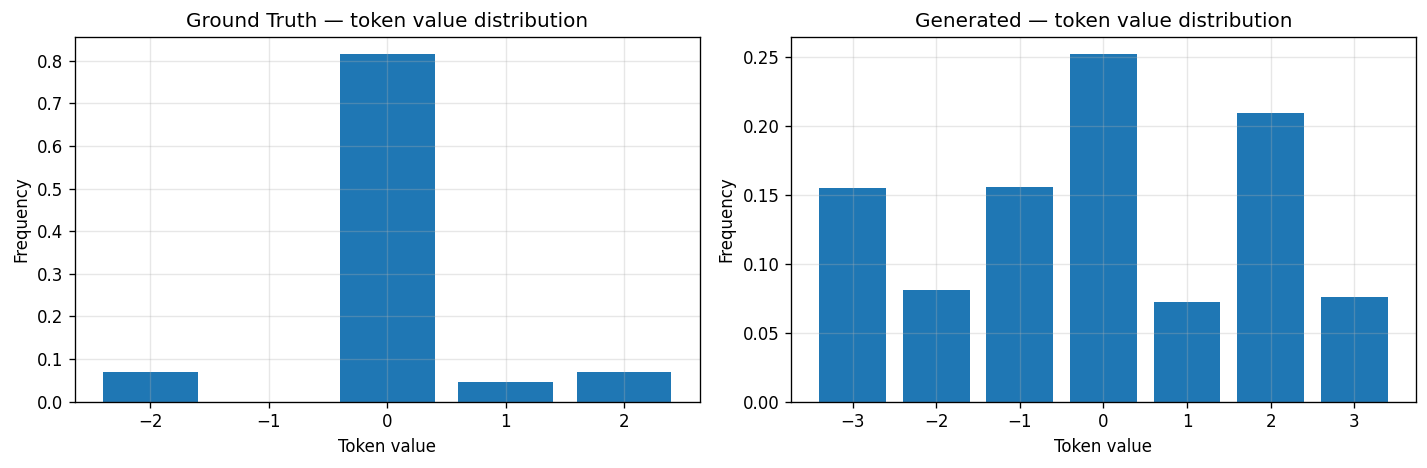

In [9]:
# Value distribution in generated vs ground truth tensors
fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=120)

gt_flat = dataset.x[:NUM_SAMPLES].cpu().float().flatten().numpy()
gen_flat = tensors_out.cpu().float().flatten().numpy()

for ax, data, title in zip(axes, [gt_flat, gen_flat], ["Ground Truth", "Generated"]):
    unique, counts = np.unique(data.round().astype(int), return_counts=True)
    ax.bar(unique, counts / counts.sum(), width=0.8)
    ax.set_xlabel("Token value")
    ax.set_ylabel("Frequency")
    ax.set_title(f"{title} — token value distribution")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Decode & Validity Analysis

In [10]:
decoded_circuits = evaluator.decode_tensors(tensors_out)

valid = [(i, qc) for i, qc in enumerate(decoded_circuits) if qc is not None]
valid_indices = [i for i, _ in valid]
backend_circuits = [qc for _, qc in valid]
n_valid = len(backend_circuits)
n_fail = len(decoded_circuits) - n_valid

print(f"Total samples    : {len(decoded_circuits)}")
print(f"Valid circuits   : {n_valid} ({100 * n_valid / len(decoded_circuits):.1f}%)")
print(f"Decode failures  : {n_fail} ({100 * n_fail / len(decoded_circuits):.1f}%)")

2026-02-13 13:53:12 - quantum_diffusion.evaluation.evaluator - INFO - Decoding tensors...


2026-02-13 13:53:12 - quantum_diffusion.evaluation.evaluator - INFO - Finished tensor decoding. Took 0.08 seconds.


Total samples    : 500
Valid circuits   : 0 (0.0%)
Decode failures  : 500 (100.0%)


## 7. SRV Evaluation Metrics

In [11]:
valid_indices_eval, target_srvs, predicted_srvs = evaluator.validate_and_calculate_srvs(
    decoded_circuits, save_output=False
)

if len(valid_indices_eval) == 0:
    print("\nWARNING: No valid circuits were decoded. SRV metrics cannot be computed.")
    print("This indicates the model is not producing decodable circuit tensors.")
    srv_exact_match_rate = 0.0
    acc_per_entanglement = {}
else:
    srv_exact_match_rate, acc_per_entanglement = evaluator.calculate_metrics(target_srvs, predicted_srvs)

    print(f"\nSRV exact match rate: {srv_exact_match_rate:.4f}")
    print("\nAccuracy per entanglement level:")
    for n_ent, acc in sorted(acc_per_entanglement.items()):
        print(f"  {n_ent} entangled qubits: {acc:.4f}")

2026-02-13 13:53:12 - quantum_diffusion.evaluation.evaluator - INFO - ==== genQC Evaluation ====


2026-02-13 13:53:12 - quantum_diffusion.evaluation.evaluator - INFO - Samples requested: 500


2026-02-13 13:53:12 - quantum_diffusion.evaluation.evaluator - INFO - Decoded circuits : 0


2026-02-13 13:53:12 - quantum_diffusion.evaluation.evaluator - INFO - Decode failures  : 500


2026-02-13 13:53:12 - quantum_diffusion.evaluation.evaluator - INFO - Calculating SRVs...


2026-02-13 13:53:12 - quantum_diffusion.evaluation.evaluator - INFO - Finished SRV calculation. Took 0.00 seconds.



This indicates the model is not producing decodable circuit tensors.


In [12]:
# Bar chart of accuracy per entanglement level
if acc_per_entanglement:
    ent_levels = sorted(acc_per_entanglement.keys())
    accs = [acc_per_entanglement[k] for k in ent_levels]

    fig, ax = plt.subplots(figsize=(6, 4), dpi=120)
    bars = ax.bar(ent_levels, accs, color="steelblue", edgecolor="white")
    for bar, acc in zip(bars, accs):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
                f"{acc:.2f}", ha="center", va="bottom", fontsize=9)
    ax.set_xlabel("Number of entangled qubits")
    ax.set_ylabel("SRV exact match accuracy")
    ax.set_title(f"Accuracy by Entanglement Level (overall: {srv_exact_match_rate:.3f})")
    ax.set_ylim(0, 1.15)
    ax.grid(True, alpha=0.3, axis="y")
    plt.tight_layout()
    plt.show()
else:
    print("No accuracy data to plot (no valid circuits).")

No accuracy data to plot (no valid circuits).


In [13]:
# Per-qubit rank accuracy
if len(valid_indices_eval) > 0 and target_srvs.shape == predicted_srvs.shape:
    per_qubit_acc = (predicted_srvs == target_srvs).float().mean(dim=0)
    print("Per-qubit rank accuracy:")
    for i, acc in enumerate(per_qubit_acc.tolist()):
        print(f"  Qubit {i}: {acc:.4f}")
else:
    print("No valid circuits — per-qubit accuracy not available.")

No valid circuits — per-qubit accuracy not available.


## 8. Confusion Analysis

In [14]:
# Entanglement-level confusion matrix
if len(valid_indices_eval) > 0:
    # Entanglement level = number of qubits with SRV value == 2
    target_ent = (target_srvs == 2).sum(dim=1).numpy()
    pred_ent = (predicted_srvs == 2).sum(dim=1).numpy()

    max_ent = max(target_ent.max(), pred_ent.max()) + 1
    confusion = np.zeros((max_ent, max_ent), dtype=int)
    for t, p in zip(target_ent, pred_ent):
        confusion[t, p] += 1

    # Normalize rows
    row_sums = confusion.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    confusion_norm = confusion / row_sums

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=120)

    for ax, data, title, fmt in zip(axes,
                                     [confusion, confusion_norm],
                                     ["Counts", "Row-normalized"],
                                     ["d", ".2f"]):
        im = ax.imshow(data, cmap="Blues", origin="lower")
        ax.set_xlabel("Predicted entanglement")
        ax.set_ylabel("Target entanglement")
        ax.set_title(f"Entanglement Confusion ({title})")
        fig.colorbar(im, ax=ax, shrink=0.8)
        # Annotate cells
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                if data[i, j] > 0:
                    ax.text(j, i, f"{data[i, j]:{fmt}}", ha="center", va="center",
                            fontsize=8, color="white" if data[i, j] > data.max() * 0.5 else "black")

    plt.tight_layout()
    plt.show()
else:
    print("No valid circuits — confusion matrix not available.")

No valid circuits — confusion matrix not available.


In [15]:
# Per-qubit value confusion: how often does the model predict 1 vs 2 for each qubit?
if len(valid_indices_eval) > 0:
    fig, axes = plt.subplots(1, evaluator.num_qubits, figsize=(3 * evaluator.num_qubits, 3), dpi=120)
    if evaluator.num_qubits == 1:
        axes = [axes]

    for q in range(evaluator.num_qubits):
        ax = axes[q]
        t_vals = target_srvs[:, q].numpy()
        p_vals = predicted_srvs[:, q].numpy()
        # 2x2 confusion for SRV values 1 and 2
        cm = np.zeros((2, 2), dtype=int)
        for t, p in zip(t_vals, p_vals):
            ti = 0 if t == 1 else 1
            pi = 0 if p == 1 else 1
            cm[ti, pi] += 1
        cm_norm = cm / cm.sum(axis=1, keepdims=True).clip(1)
        im = ax.imshow(cm_norm, cmap="Blues", vmin=0, vmax=1)
        for i in range(2):
            for j in range(2):
                ax.text(j, i, f"{cm_norm[i, j]:.2f}\n({cm[i, j]})",
                        ha="center", va="center", fontsize=8)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(["1", "2"])
        ax.set_yticks([0, 1])
        ax.set_yticklabels(["1", "2"])
        ax.set_xlabel("Predicted")
        if q == 0:
            ax.set_ylabel("Target")
        ax.set_title(f"Qubit {q}")

    plt.suptitle("Per-qubit SRV value confusion (1=separable, 2=entangled)", y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No valid circuits — per-qubit confusion not available.")

No valid circuits — per-qubit confusion not available.


## 9. Circuit Structure Analysis

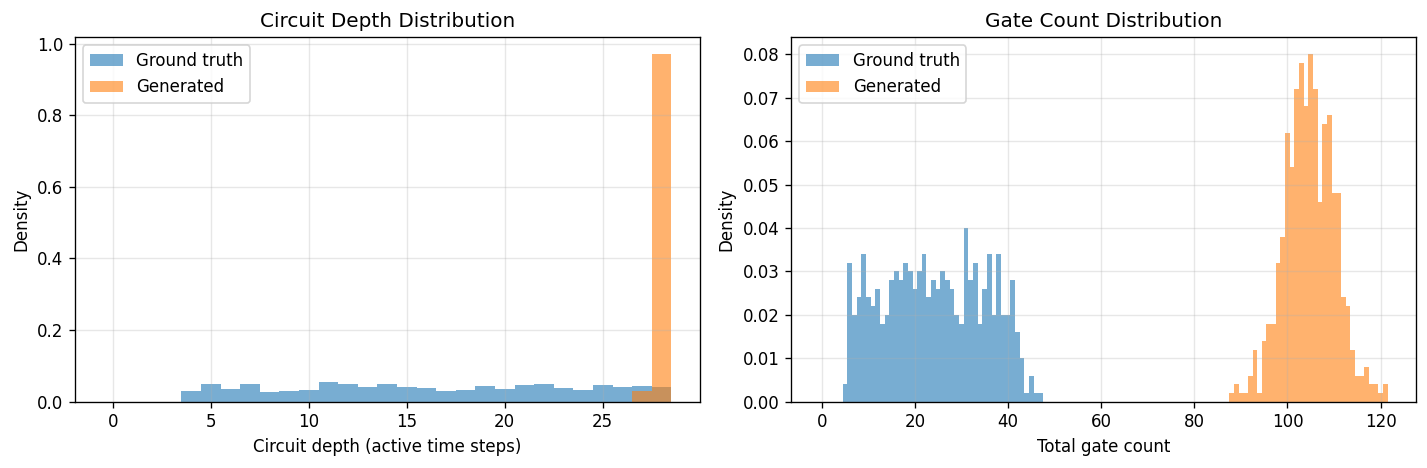

In [16]:
# Gate usage: count nonzero tokens in generated vs ground truth
gt_subset = dataset.x[evaluator.idx].cpu()

# Circuit depth = number of time steps with at least one gate
gen_depths = (tensors_out.cpu().round().long() != 0).any(dim=1).sum(dim=1).numpy()
gt_depths = (gt_subset != 0).any(dim=1).sum(dim=1).numpy()

# Total gate count per circuit
gen_gate_counts = (tensors_out.cpu().round().long() != 0).sum(dim=(1, 2)).numpy()
gt_gate_counts = (gt_subset != 0).sum(dim=(1, 2)).numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=120)

ax = axes[0]
bins = np.arange(0, max(gen_depths.max(), gt_depths.max()) + 2) - 0.5
ax.hist(gt_depths, bins=bins, alpha=0.6, label="Ground truth", density=True)
ax.hist(gen_depths, bins=bins, alpha=0.6, label="Generated", density=True)
ax.set_xlabel("Circuit depth (active time steps)")
ax.set_ylabel("Density")
ax.set_title("Circuit Depth Distribution")
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
bins = np.arange(0, max(gen_gate_counts.max(), gt_gate_counts.max()) + 2) - 0.5
ax.hist(gt_gate_counts, bins=bins, alpha=0.6, label="Ground truth", density=True)
ax.hist(gen_gate_counts, bins=bins, alpha=0.6, label="Generated", density=True)
ax.set_xlabel("Total gate count")
ax.set_ylabel("Density")
ax.set_title("Gate Count Distribution")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# Token-level distribution (gate type frequencies)
vocabulary = {gate: idx for idx, gate in enumerate(dataset.gate_pool)}
inv_vocab = {v + 1: k for k, v in vocabulary.items()}  # +1 because tokenizer increments
inv_vocab[0] = "<pad>"

gen_tokens = tensors_out.cpu().round().long().flatten().numpy()
gt_tokens = gt_subset.flatten().numpy()

# Count absolute token values (control nodes are negative)
gen_abs = np.abs(gen_tokens)
gt_abs = np.abs(gt_tokens)

all_token_ids = sorted(set(gen_abs.tolist()) | set(gt_abs.tolist()))
gen_counts = Counter(gen_abs.tolist())
gt_counts = Counter(gt_abs.tolist())
gen_total = sum(gen_counts.values())
gt_total = sum(gt_counts.values())

print(f"{'Token ID':>10} {'Gate':>8} {'GT freq':>10} {'Gen freq':>10}")
print("-" * 42)
for tid in all_token_ids:
    name = inv_vocab.get(tid, f"?{tid}")
    gt_f = gt_counts.get(tid, 0) / gt_total
    gen_f = gen_counts.get(tid, 0) / gen_total
    print(f"{tid:>10} {name:>8} {gt_f:>10.4f} {gen_f:>10.4f}")

  Token ID     Gate    GT freq   Gen freq
------------------------------------------
         0    <pad>     0.8273     0.2517
         1        h     0.0587     0.2278
         2       cx     0.1141     0.2896
         3       ?3     0.0000     0.2309


In [18]:
# Visualize a few decoded circuits
if backend_circuits:
    simulator = Simulator(CircuitBackendType.QUDITKIT)
    n_draw = min(4, len(backend_circuits))

    for i in range(n_draw):
        orig_idx = valid_indices[i]
        target_label = str(dataset.y[evaluator.idx[orig_idx]])
        print(f"\nCircuit {i} — Target: {target_label}")
        try:
            display(simulator.draw(backend_circuits[i]))
        except Exception as e:
            print(f"  Could not draw circuit: {e}")
else:
    print("No valid circuits to draw.")

No valid circuits to draw.


## 10. Guidance Scale Sweep

Generate small batches at different guidance scales to check if the model responds to conditioning.

In [19]:
guidance_scales = [0.5, 1.0, 1.5, 3.0, 5.0]
sweep_samples = 100
sweep_idx = evaluator.idx[:sweep_samples]
sweep_prompts = [str(dataset.y[i]) for i in sweep_idx]

sweep_results = {}

for g in guidance_scales:
    print(f"\nGuidance scale = {g}")
    t_out = generate_tensors(
        pipeline=pipeline,
        prompt=sweep_prompts,
        samples=sweep_samples,
        system_size=evaluator.system_size,
        num_of_qubits=evaluator.num_qubits,
        max_gates=evaluator.max_gates,
        g=g,
        auto_batch_size=cfg.model_params.auto_batch_size,
        enable_params=False,
        no_bar=True,
    )

    tokenizer = CircuitTokenizer(vocabulary)
    sim = Simulator(CircuitBackendType.QUDITKIT)
    dec, _ = decode_tensors_to_backend(
        simulator=sim, tokenizer=tokenizer, tensors=t_out,
        params=None, silent=True, n_jobs=1, filter_errs=False,
    )

    valid_g = [(i, qc) for i, qc in enumerate(dec) if qc is not None]
    if not valid_g:
        print(f"  No valid circuits at g={g}")
        sweep_results[g] = {"valid_rate": 0.0, "exact_match": 0.0}
        continue

    vi = [i for i, _ in valid_g]
    bc = [qc for _, qc in valid_g]
    valid_rate = len(bc) / sweep_samples

    target = SRVEvaluator._parse_srv_targets(dataset.y[sweep_idx])[vi]
    predicted = torch.tensor(get_srvs(sim, bc, n_jobs=1), dtype=torch.long)

    if target.shape == predicted.shape:
        em = (predicted == target).all(dim=1).float().mean().item()
    else:
        em = 0.0

    sweep_results[g] = {"valid_rate": valid_rate, "exact_match": em}
    print(f"  Valid: {valid_rate:.2%}, Exact match: {em:.4f}")


Guidance scale = 0.5


[WARNING]: The value 0 is reserved for background tokens, i.e. qubit time position which are not effected by gates.
[WARNING]: Automatically incrementing all vocabulary values by one ...
  No valid circuits at g=0.5

Guidance scale = 1.0


[WARNING]: The value 0 is reserved for background tokens, i.e. qubit time position which are not effected by gates.
[WARNING]: Automatically incrementing all vocabulary values by one ...
  No valid circuits at g=1.0

Guidance scale = 1.5


[WARNING]: The value 0 is reserved for background tokens, i.e. qubit time position which are not effected by gates.
[WARNING]: Automatically incrementing all vocabulary values by one ...
  No valid circuits at g=1.5

Guidance scale = 3.0


[WARNING]: The value 0 is reserved for background tokens, i.e. qubit time position which are not effected by gates.
[WARNING]: Automatically incrementing all vocabulary values by one ...
  No valid circuits at g=3.0

Guidance scale = 5.0


[WARNING]: The value 0 is reserved for background tokens, i.e. qubit time position which are not effected by gates.
[WARNING]: Automatically incrementing all vocabulary values by one ...
  No valid circuits at g=5.0


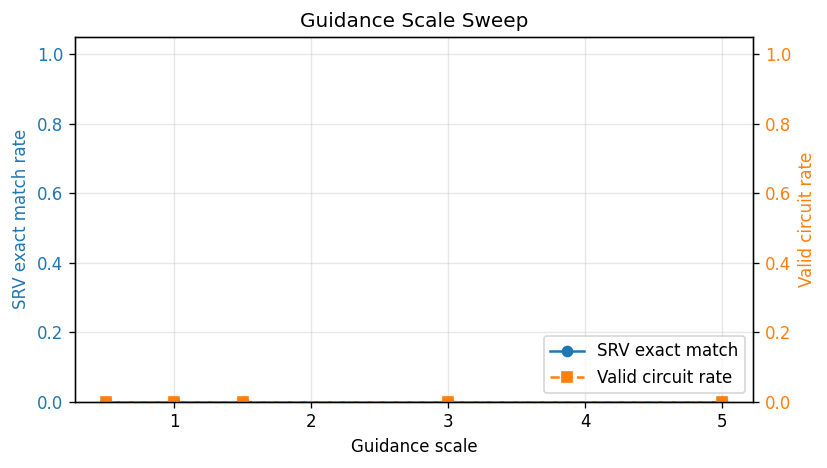

In [20]:
if sweep_results:
    gs = sorted(sweep_results.keys())
    em_vals = [sweep_results[g]["exact_match"] for g in gs]
    vr_vals = [sweep_results[g]["valid_rate"] for g in gs]

    fig, ax1 = plt.subplots(figsize=(7, 4), dpi=120)
    ax1.plot(gs, em_vals, "o-", color="C0", label="SRV exact match")
    ax1.set_xlabel("Guidance scale")
    ax1.set_ylabel("SRV exact match rate", color="C0")
    ax1.tick_params(axis="y", labelcolor="C0")
    ax1.set_ylim(0, 1.05)

    ax2 = ax1.twinx()
    ax2.plot(gs, vr_vals, "s--", color="C1", label="Valid circuit rate")
    ax2.set_ylabel("Valid circuit rate", color="C1")
    ax2.tick_params(axis="y", labelcolor="C1")
    ax2.set_ylim(0, 1.05)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="lower right")

    ax1.set_title("Guidance Scale Sweep")
    ax1.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 11. Summary

**Key things to check:**

1. **Training curves** (Section 2): Did the loss converge? Is there a gap between train and validation loss suggesting overfitting?
2. **Raw tensor outputs** (Section 5): Do the generated tensors visually resemble the ground truth structure (sparsity pattern, value distribution)?
3. **Decode validity** (Section 6): What fraction of generated tensors produce valid circuits? Low validity suggests the model hasn't learned the grammar of valid circuits.
4. **SRV accuracy** (Section 7): Does the model generate circuits with the correct entanglement structure? Higher accuracy for low-entanglement targets is expected.
5. **Confusion patterns** (Section 8): Which entanglement levels get confused? Per-qubit confusion shows if specific qubits are harder.
6. **Circuit structure** (Section 9): Does the model match the depth/gate-count distribution of the training data? Large mismatches indicate structural problems.
7. **Guidance sweep** (Section 10): Does increasing guidance improve conditioning? If accuracy is flat across guidance scales, the model may not have learned the text-circuit relationship.